# Поиск по изображениям — PoC

Демонстрационный проект поиска референсных фотографий по текстовому описанию.
Ниже приведён полный пайплайн: загрузка данных, EDA, подготовка и фильтрация, векторизация, обучение моделей, выбор лучшей и демонстрация поиска.


### Описание данных

Данные находятся в папке `to_upload`.

- В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.
- В папке `train_images` содержатся изображения для тренировки модели.
- В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга:
  1. Имя файла изображения.
  2. Идентификатор описания.
  3. Доля людей, подтвердивших, что описание соответствует изображению.
  4. Количество человек, подтвердивших, что описание соответствует изображению.
  5. Количество человек, подтвердивших, что описание не соответствует изображению.
- В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов:
  1. Имя файла изображения.
  2. Идентификатор описания.
  3–5 — оценки трёх экспертов.
  Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.
- В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.
- В папке `test_images` содержатся изображения для тестирования модели.


## Импорты и конфигурация
- Импорты библиотек, фиксация seed.
- Настройка путей к данным и изображениям.


In [1]:
!pip install numpy pandas matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q
!pip install torch torchvision -q
!pip install sentence_transformers -q
!pip install transformers -q
!pip install scipy -q

In [2]:
import warnings
import re
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, normalize
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

BASE_DIR = Path("/Users/apple/Desktop/DS_project/project_5")
DATA_DIR = BASE_DIR / "to_upload"

TRAIN_CSV = DATA_DIR / "train_dataset.csv"
CROWD_TSV = DATA_DIR / "CrowdAnnotations.tsv"
EXPERT_TSV = DATA_DIR / "ExpertAnnotations.tsv"
TEST_QUERIES_CSV = DATA_DIR / "test_queries.csv"
TEST_IMAGES_CSV = DATA_DIR / "test_images.csv"

TRAIN_IMAGES_DIR = DATA_DIR / "train_images"
TEST_IMAGES_DIR = DATA_DIR / "test_images"


## Загрузка данных
- Чтение train/test таблиц и аннотаций.
- Приведение колонок к единому виду.
- Первичная проверка структуры.


In [3]:
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip().strip("|") for c in df.columns]
    return df

train_df = pd.read_csv(TRAIN_CSV)

crowd_df = pd.read_csv(
    CROWD_TSV,
    sep="\t",
    header=None,
    names=["image", "query_id", "crowd_share", "crowd_yes", "crowd_no"],
)

expert_df = pd.read_csv(
    EXPERT_TSV,
    sep="\t",
    header=None,
    names=["image", "query_id", "expert_1", "expert_2", "expert_3"],
)

# test_queries имеет разделитель '|' и пустые крайние колонки
raw_test_queries = pd.read_csv(TEST_QUERIES_CSV, sep="|", engine="python")
raw_test_queries = normalize_columns(raw_test_queries)
raw_test_queries = raw_test_queries[[c for c in raw_test_queries.columns if c and "Unnamed" not in c]]

if set(["query_id", "query_text", "image"]).issubset(raw_test_queries.columns):
    test_queries = raw_test_queries[["query_id", "query_text", "image"]].copy()
else:
    test_queries = raw_test_queries.copy()
    test_queries.columns = ["query_id", "query_text", "image"]


def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["query_text"] = train_df["query_text"].astype(str)
train_df["query_text_clean"] = train_df["query_text"].apply(clean_text)

test_queries["query_text"] = test_queries["query_text"].astype(str)
test_queries["query_text_clean"] = test_queries["query_text"].apply(clean_text)

test_images = pd.read_csv(TEST_IMAGES_CSV)

# Приводим строковые колонки к единому виду
for df in [train_df, crowd_df, expert_df, test_queries, test_images]:
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.strip()

display(train_df.head())
display(crowd_df.head())
display(expert_df.head())
display(test_queries.head())
display(test_images.head())


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A young child is wearing blue goggles and sitt...   
2  A young child is wearing blue goggles and sitt...   
3  A young child is wearing blue goggles and sitt...   
4  A young child is wearing blue goggles and sitt...   

                                    query_text_clean  
0  a young child is wearing blue goggles and sitt...  
1  a young child is wearing blue goggles and sitt...  
2  a young child is wearing blue goggles and sitt...  
3  a young child is wearing blue goggles and sitt...  
4  a young child is wearing blue goggles and sitt...

image                     query_id  crowd_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

   crowd_yes  crowd_no  
0          3         0  
1          0         3  
2          0         3  
3          0         3  
4          0         3

image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  \
0  1177994172_10d143cb8d.jpg   
1  1177994172_10d143cb8d.jpg   
2  1177994172_10d143cb8d.jpg   
3  1177994172_10d143cb8d.jpg   
4  1177994172_10d143cb8d.jpg   

                                    query_text_clean  
0  two blonde boys one in a camouflage shirt and ...  
1    two boys are squirting water guns at each other  
2            two boys spraying each other with water  
3  two children wearing jeans squirt water at eac...  
4   two young boys are squirting water at each other

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение–текст имеются оценки от трёх специалистов. Для решения задачи эти оценки нужно агрегировать — превратить в одну.
Существует несколько способов агрегации, самый простой — голосование большинства (2 из 3). В текущей реализации экспертные оценки переводятся в бинарную шкалу (1–2 → 0, 3–4 → 1), далее берётся большинство.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:
1. Доля исполнителей, подтвердивших, что текст соответствует картинке.
2. Количество исполнителей, подтвердивших, что текст соответствует картинке.
3. Количество исполнителей, подтвердивших, что текст не соответствует картинке.

После анализа экспертных и краудсорсинговых оценок можно выбрать одну из них либо объединить, например, с коэффициентами 0.6/0.4. Здесь мы рассчитываем `target_expert`, `target_crowd` и `target_mix` и далее выбираем лучшую стратегию по валидации.

Модель возвращает вероятность соответствия изображения тексту, поэтому целевая переменная находится в диапазоне [0, 1].


train_df: (5822, 4)
crowd_df: (47830, 5)
expert_df: (5822, 5)
test_queries: (500, 4)
test_images: (100, 1)

Уникальные изображения в train: 1000
Уникальные query_id в train: 977

Длина текстов (train):
count    5822.000000
mean       11.900550
std         4.162467
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        34.000000
Name: text_len, dtype: float64


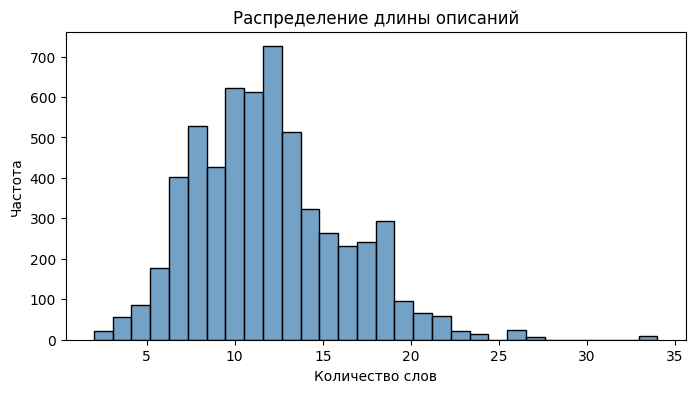

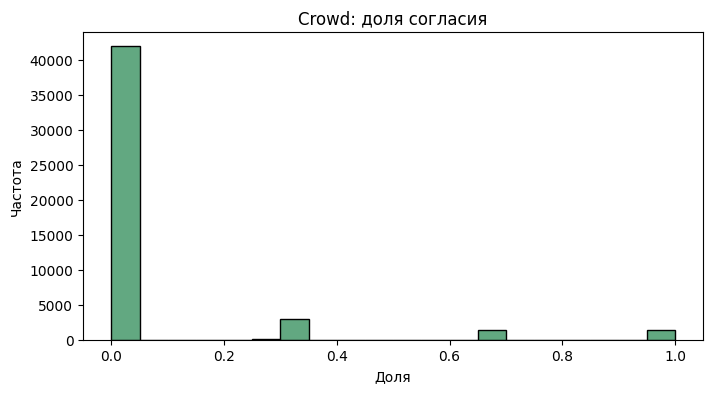

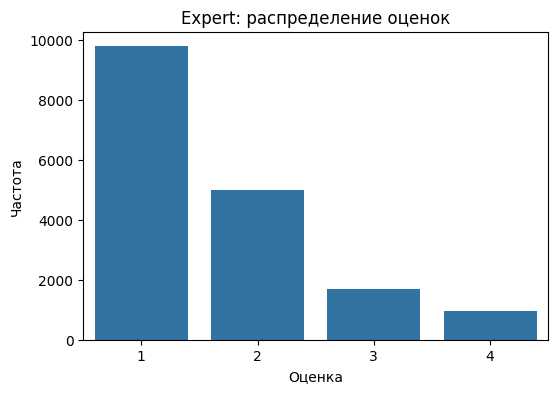

In [4]:
print("train_df:", train_df.shape)
print("crowd_df:", crowd_df.shape)
print("expert_df:", expert_df.shape)
print("test_queries:", test_queries.shape)
print("test_images:", test_images.shape)

print("\nУникальные изображения в train:", train_df["image"].nunique())
print("Уникальные query_id в train:", train_df["query_id"].nunique())

# Длина текстов
train_df["text_len"] = train_df["query_text"].astype(str).str.split().str.len()
print("\nДлина текстов (train):")
print(train_df["text_len"].describe())

plt.figure(figsize=(8, 4))
sns.histplot(train_df["text_len"], bins=30, color="steelblue")
plt.title("Распределение длины описаний")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.show()

# Crowdsourcing: доля согласия
plt.figure(figsize=(8, 4))
sns.histplot(crowd_df["crowd_share"].astype(float), bins=20, color="seagreen")
plt.title("Crowd: доля согласия")
plt.xlabel("Доля")
plt.ylabel("Частота")
plt.show()

# Expert: распределение оценок
expert_scores = pd.concat([
    expert_df["expert_1"],
    expert_df["expert_2"],
    expert_df["expert_3"],
]).astype(int)

plt.figure(figsize=(6, 4))
sns.countplot(x=expert_scores)
plt.title("Expert: распределение оценок")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.show()

train_df.drop(columns=["text_len"], inplace=True)


## Агрегация экспертных и крауд-оценок
- Для экспертов — бинаризация: 1–2 → 0, 3–4 → 1; агрегируем по большинству среди 3 экспертов.
- Для крауда — используем долю согласия.
- Собираем несколько вариантов целевой переменной.


In [5]:
def expert_to_binary(value: int) -> int:
    return 1 if int(value) >= 3 else 0

expert_binary = expert_df[["expert_1", "expert_2", "expert_3"]].apply(
    lambda col: col.map(expert_to_binary)
)
expert_df["target_expert"] = (expert_binary.sum(axis=1) >= 2).astype(int)

crowd_df["target_crowd"] = crowd_df["crowd_share"].astype(float).clip(0, 1)

train_full = train_df.merge(
    expert_df[["image", "query_id", "target_expert"]],
    on=["image", "query_id"],
    how="left",
)
train_full = train_full.merge(
    crowd_df[["image", "query_id", "target_crowd"]],
    on=["image", "query_id"],
    how="left",
)
train_full["target_mix"] = 0.6 * train_full["target_expert"] + 0.4 * train_full["target_crowd"]

print("Доля строк с экспертной оценкой:", train_full["target_expert"].notna().mean())
print("Доля строк с крауд-оценкой:", train_full["target_crowd"].notna().mean())
print("Доля строк с mix-оценкой:", train_full["target_mix"].notna().mean())

train_full.head()


Доля строк с экспертной оценкой: 1.0
Доля строк с крауд-оценкой: 0.4000343524562006
Доля строк с mix-оценкой: 0.4000343524562006


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  \
0  A young child is wearing blue goggles and sitt...   
1  A young child is wearing blue goggles and sitt...   
2  A young child is wearing blue goggles and sitt...   
3  A young child is wearing blue goggles and sitt...   
4  A young child is wearing blue goggles and sitt...   

                                    query_text_clean  target_expert  \
0  a young child is wearing blue goggles and sitt...              0   
1  a young child is wearing blue goggles and sitt...              0   
2  a young child is wearing blue goggles and sitt...              0   
3  a young child is wearing blue goggles and sitt...              1   
4  a young child is wearing blue goggles and sitt...              0   

   target_crowd  target_mix  
0           0.0         0.0  
1           NaN         NaN  
2           0.0         0.0  
3           1.0         1.0  
4           NaN         NaN

## 2. Проверка данных

В некоторых странах действуют ограничения по обработке изображений: сервисам запрещено предоставлять информацию, содержащую описание, изображение или запись голоса детей (до 16 лет) без разрешения родителей или законных представителей.

В рабочем продукте вместо таких изображений показывается дисклеймер:
> This image is unavailable in your country in compliance with local laws

В PoC мы не можем применить механизм блокировки, поэтому исключаем такие объекты из обучающей выборки и используем проверку запроса на инференсе.


In [6]:
RESTRICTED_WORDS = [
    "child", "children", "kid", "kids", "boy", "boys", "girl", "girls",
    "baby", "babies", "toddler", "toddlers", "teen", "teens",
    "schoolboy", "schoolboys", "schoolgirl", "schoolgirls",
]
restricted_pattern = re.compile(r"\b(" + "|".join(RESTRICTED_WORDS) + r")\b", re.IGNORECASE)

def is_restricted_query(text: str) -> bool:
    if not isinstance(text, str):
        return False
    return bool(restricted_pattern.search(text))

train_full["is_restricted"] = train_full["query_text"].apply(is_restricted_query)
removed_share = train_full["is_restricted"].mean()

train_filtered = train_full.loc[~train_full["is_restricted"]].copy()
train_filtered = train_filtered.reset_index(drop=True)
train_filtered["row_id"] = np.arange(len(train_filtered))

print(f"Удалено по юридическим ограничениям: {removed_share:.2%}")
print("Размер train после фильтрации:", train_filtered.shape)


Удалено по юридическим ограничениям: 26.74%
Размер train после фильтрации: (4265, 9)


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Возможные способы:
- TF‑IDF;
- word2vec;
- трансформеры (например, BERT).

В проекте использованы TF‑IDF (на очищенном тексте) и Sentence‑BERT (на исходном тексте), далее выбирается лучший вариант по метрикам.


In [7]:
def build_tfidf(texts: pd.Series) -> tuple[TfidfVectorizer, np.ndarray]:
    vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=2)
    matrix = vectorizer.fit_transform(texts)
    return vectorizer, matrix

text_embeddings = {}
text_pipelines = {}

# TF-IDF
vectorizer_tfidf, tfidf_matrix = build_tfidf(train_filtered["query_text_clean"])
text_embeddings["tfidf"] = tfidf_matrix
text_pipelines["tfidf"] = {
    "name": "tfidf",
    "vectorizer": vectorizer_tfidf,
}

print("TF-IDF размерность:", tfidf_matrix.shape)

# Sentence-BERT (опционально)
sbert_model = None
sbert_matrix = None
try:
    from sentence_transformers import SentenceTransformer

    sbert_model = SentenceTransformer(
        "sentence-transformers/all-MiniLM-L6-v2",
        device=str(device),
    )
    sbert_matrix = sbert_model.encode(
        train_filtered["query_text"].tolist(),
        batch_size=64,
        show_progress_bar=True,
        normalize_embeddings=True,
    )
    text_embeddings["sbert"] = sbert_matrix
    text_pipelines["sbert"] = {
        "name": "sbert",
        "model": sbert_model,
    }
    print("SBERT размерность:", sbert_matrix.shape)
except Exception as exc:
    print("Sentence-BERT не доступен:", exc)


TF-IDF размерность: (4265, 4380)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1459.50it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 67/67 [00:03<00:00, 21.32it/s]

SBERT размерность: (4265, 384)


## 3. Векторизация изображений

Самый примитивный способ — прочесть изображение и превратить матрицу в вектор — не подходит: размеры изображений разные. Поэтому используем свёрточную сеть для выделения ключевых признаков. В проекте применяется ResNet50 (предобученная на ImageNet) без классификационной головы, что даёт фиксированный эмбеддинг изображения.


In [8]:
weights = models.ResNet50_Weights.IMAGENET1K_V2
preprocess = weights.transforms()

resnet = models.resnet50(weights=weights)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        return str(path), self.transform(image)


def build_image_embeddings(image_paths, batch_size=32):
    dataset = ImageDataset(image_paths, preprocess)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    embeddings = {}
    with torch.no_grad():
        for paths, batch in loader:
            batch = batch.to(device)
            features = resnet(batch).cpu().numpy()
            for p, f in zip(paths, features):
                embeddings[Path(p).name] = f
    return embeddings


def load_or_build_embeddings(cache_path: Path, image_paths):
    if cache_path.exists():
        return np.load(cache_path, allow_pickle=True).item()
    embeddings = build_image_embeddings(image_paths)
    np.save(cache_path, embeddings, allow_pickle=True)
    return embeddings

# Готовим список доступных train изображений
train_image_names = sorted(train_filtered["image"].unique())
train_image_paths = [TRAIN_IMAGES_DIR / name for name in train_image_names]

missing_train = [p for p in train_image_paths if not p.exists()]
if missing_train:
    print(f"Не найдено train изображений: {len(missing_train)}. Пример: {missing_train[:3]}")

available_train_images = [p for p in train_image_paths if p.exists()]
train_image_embeddings = load_or_build_embeddings(
    CACHE_DIR / "train_image_embeddings.npy",
    available_train_images,
)

# Готовим список test изображений из test_images.csv
if "image" in test_images.columns:
    test_image_names = test_images["image"].unique().tolist()
else:
    test_image_names = test_images.iloc[:, 0].astype(str).tolist()

test_image_paths = [TEST_IMAGES_DIR / name for name in test_image_names]
missing_test = [p for p in test_image_paths if not p.exists()]
if missing_test:
    print(f"Не найдено test изображений: {len(missing_test)}. Пример: {missing_test[:3]}")

available_test_images = [p for p in test_image_paths if p.exists()]

test_image_embeddings = load_or_build_embeddings(
    CACHE_DIR / "test_image_embeddings.npy",
    available_test_images,
)

print("Train эмбеддинги:", len(train_image_embeddings))
print("Test эмбеддинги:", len(test_image_embeddings))


Train эмбеддинги: 993
Test эмбеддинги: 100


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.


In [9]:
from scipy import sparse

# Оставляем только строки, для которых есть эмбеддинги изображений
available_train_set = set(train_image_embeddings.keys())
train_ready = train_filtered[train_filtered["image"].isin(available_train_set)].copy()

print("Размер train_ready:", train_ready.shape)


def l2_normalize_matrix(matrix):
    if sparse.issparse(matrix):
        return normalize(matrix, norm="l2", copy=False)
    return normalize(matrix, norm="l2")


def build_feature_matrix(df: pd.DataFrame, text_matrix, image_embeddings: dict):
    idx = df["row_id"].to_numpy() if "row_id" in df.columns else df.index.to_numpy()
    X_img = np.vstack([image_embeddings[img] for img in df["image"]])
    X_img = l2_normalize_matrix(X_img)

    if sparse.issparse(text_matrix):
        X_text = text_matrix[idx]
        X_text = l2_normalize_matrix(X_text)
        X = sparse.hstack([sparse.csr_matrix(X_img), X_text])
    else:
        X_text = text_matrix[idx]
        X_text = l2_normalize_matrix(X_text)
        X = np.hstack([X_img, X_text])
    return X

# Пример размерности для TF-IDF
X_example = build_feature_matrix(train_ready.head(5), text_embeddings["tfidf"], train_image_embeddings)
print("Пример размерности X:", X_example.shape)


Размер train_ready: (4265, 9)
Пример размерности X: (5, 6428)


## Разбиение train/valid/test без утечки по изображениям
- Используем GroupShuffleSplit, группируем по `image`.
- Гарантируем, что одно и то же изображение не попадает в разные сплиты.


In [10]:
def split_by_image(df: pd.DataFrame, train_size: float = 0.7):
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=RANDOM_STATE)
    train_idx, val_idx = next(gss.split(df, groups=df["image"]))
    return df.iloc[train_idx], df.iloc[val_idx]

train_demo, val_demo = split_by_image(train_ready)
print("Train/Val размеры:", train_demo.shape, val_demo.shape)

intersection = set(train_demo["image"]).intersection(set(val_demo["image"]))
print("Пересечение изображений между train и val:", len(intersection))


Train/Val размеры: (3018, 9) (1247, 9)
Пересечение изображений между train и val: 0


## 6. Обучение модели предсказания соответствия

Для обучения разделяем датасет на тренировочную и валидационную выборки. Простое случайное разбиение не подходит: нужно исключить попадание одного изображения и в train, и в val. Для этого используем `GroupShuffleSplit` с группировкой по `image`.

Пример:
```
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]
```

В качестве моделей рассматриваем:
1) Линейную регрессию (baseline);
2) Полносвязную нейронную сеть (MLP).
Также выбираем метрики качества и сравниваем модели.


In [11]:
def evaluate_target_strategy(df: pd.DataFrame, target_col: str):
    df_target = df[df[target_col].notna()].copy()
    if df_target.empty:
        return np.inf

    y = df_target[target_col].astype(float)
    train_df, val_df = split_by_image(df_target)

    X_train = build_feature_matrix(train_df, text_embeddings["tfidf"], train_image_embeddings)
    X_val = build_feature_matrix(val_df, text_embeddings["tfidf"], train_image_embeddings)

    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y.loc[train_df.index])
    preds = model.predict(X_val_scaled)

    mae = mean_absolute_error(y.loc[val_df.index], preds)
    return mae

# Выбор лучшей цели по базовой метрике
candidate_targets = ["target_expert", "target_crowd", "target_mix"]
mae_by_target = {}
for target in candidate_targets:
    mae_by_target[target] = evaluate_target_strategy(train_ready, target)

mae_by_target

best_target = min(mae_by_target, key=mae_by_target.get)
print("Лучшая стратегия цели:", best_target)

# Финальный датасет под выбранную цель
train_final = train_ready[train_ready[best_target].notna()].copy()

# Сплит для обучения
train_split, val_split = split_by_image(train_final)

y_train = train_split[best_target].astype(float)
y_val = val_split[best_target].astype(float)

# ===== Linear Regression (TF-IDF) =====
X_train_lr = build_feature_matrix(train_split, text_embeddings["tfidf"], train_image_embeddings)
X_val_lr = build_feature_matrix(val_split, text_embeddings["tfidf"], train_image_embeddings)

scaler_lr = MaxAbsScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
X_val_lr_scaled = scaler_lr.transform(X_val_lr)

model_lr = LinearRegression()
model_lr.fit(X_train_lr_scaled, y_train)

preds_lr = np.clip(model_lr.predict(X_val_lr_scaled), 0, 1)

metrics_lr = {
    "mae": mean_absolute_error(y_val, preds_lr),
    "mse": mean_squared_error(y_val, preds_lr),
    "r2": r2_score(y_val, preds_lr),
}

# ===== MLP (SBERT или TF-IDF+SVD) =====
mlp_text_pipeline = None
if "sbert" in text_embeddings:
    text_matrix_mlp = text_embeddings["sbert"]
    mlp_text_pipeline = text_pipelines["sbert"]
    print("MLP: используем SBERT")
else:
    svd = TruncatedSVD(n_components=300, random_state=RANDOM_STATE)
    text_matrix_mlp = svd.fit_transform(text_embeddings["tfidf"])
    mlp_text_pipeline = {
        "name": "tfidf_svd",
        "vectorizer": text_pipelines["tfidf"]["vectorizer"],
        "svd": svd,
    }
    print("MLP: используем TF-IDF + SVD")

X_train_mlp = build_feature_matrix(train_split, text_matrix_mlp, train_image_embeddings)
X_val_mlp = build_feature_matrix(val_split, text_matrix_mlp, train_image_embeddings)

X_train_mlp = X_train_mlp.toarray() if sparse.issparse(X_train_mlp) else X_train_mlp
X_val_mlp = X_val_mlp.toarray() if sparse.issparse(X_val_mlp) else X_val_mlp

scaler_mlp = StandardScaler()
X_train_mlp = scaler_mlp.fit_transform(X_train_mlp)
X_val_mlp = scaler_mlp.transform(X_val_mlp)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_dims=(512, 128), dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


def train_mlp_model(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    epochs: int = 20,
    batch_size: int = 256,
    lr: float = 1e-3,
    patience: int = 5,
):
    train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

    train_ds = torch.utils.data.TensorDataset(train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model = MLPRegressor(input_dim=X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(val_tensor.to(device)).cpu().numpy().reshape(-1)
            val_mae = mean_absolute_error(y_val, val_preds)

        if val_mae + 1e-6 < best_val:
            best_val = val_mae
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

model_mlp = train_mlp_model(X_train_mlp, y_train, X_val_mlp, y_val)

model_mlp.eval()
with torch.no_grad():
    preds_mlp = model_mlp(torch.tensor(X_val_mlp, dtype=torch.float32, device=device))
    preds_mlp = preds_mlp.cpu().numpy().reshape(-1)

preds_mlp = np.clip(preds_mlp, 0, 1)

metrics_mlp = {
    "mae": mean_absolute_error(y_val, preds_mlp),
    "mse": mean_squared_error(y_val, preds_mlp),
    "r2": r2_score(y_val, preds_mlp),
}

model_results = [
    {
        "name": "LinearRegression",
        "type": "linear",
        "metrics": metrics_lr,
        "model": model_lr,
        "scaler": scaler_lr,
        "text_pipeline": text_pipelines["tfidf"],
        "train_df": train_split,
        "val_df": val_split,
    },
    {
        "name": "MLP",
        "type": "mlp",
        "metrics": metrics_mlp,
        "model": model_mlp,
        "scaler": scaler_mlp,
        "text_pipeline": mlp_text_pipeline,
        "train_df": train_split,
        "val_df": val_split,
    },
]

model_results


Лучшая стратегия цели: target_expert
MLP: используем SBERT


[{'name': 'LinearRegression',
  'type': 'linear',
  'metrics': {'mae': 0.2791297189962408,
   'mse': 0.16384220842558805,
   'r2': -0.2471784527352643},
  'model': LinearRegression(),
  'scaler': MaxAbsScaler(),
  'text_pipeline': {'name': 'tfidf',
   'vectorizer': TfidfVectorizer(max_features=20000, min_df=2, ngram_range=(1, 2))},
  'train_df':                           image                     query_id  \
  0     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
  1     3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
  2      463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
  4      534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
  5     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
  ...                         ...                          ...   
  4258    70995350_75d0698839.jpg  3200120942_59cfbb3437.jpg#2   
  4259   751737218_b89839a311.jpg  2170222061_e8bce4a32d.jpg#2   
  4260   799486353_f665d7b0f0.jpg  2170222061_e8bce4a32d.jpg

## Метрики и выбор лучшей модели
- Сравнение MAE/MSE/R2.
- Дополнительно — Recall@K для retrieval-сценария.


In [12]:
results_df = pd.DataFrame([
    {
        "model": m["name"],
        "mae": m["metrics"]["mae"],
        "mse": m["metrics"]["mse"],
        "r2": m["metrics"]["r2"],
    }
    for m in model_results
])

display(results_df.sort_values("mae"))


def encode_text(text: str, pipeline: dict):
    if pipeline["name"] == "tfidf":
        text = clean_text(text)
        return pipeline["vectorizer"].transform([text])
    if pipeline["name"] == "sbert":
        return pipeline["model"].encode([text], normalize_embeddings=True)
    if pipeline["name"] == "tfidf_svd":
        text = clean_text(text)
        vec = pipeline["vectorizer"].transform([text])
        return pipeline["svd"].transform(vec)
    raise ValueError("Unknown text pipeline")


def build_query_matrix(text_vec, image_names, image_embeddings, pipeline: dict):
    img_matrix = np.vstack([image_embeddings[name] for name in image_names])
    img_matrix = l2_normalize_matrix(img_matrix)

    if sparse.issparse(text_vec):
        text_block = sparse.vstack([text_vec] * len(image_names))
        text_block = l2_normalize_matrix(text_block)
        return sparse.hstack([sparse.csr_matrix(img_matrix), text_block])

    text_block = np.repeat(text_vec, len(image_names), axis=0)
    text_block = l2_normalize_matrix(text_block)
    return np.hstack([img_matrix, text_block])


def predict_scores(bundle: dict, X):
    if bundle["type"] == "linear":
        X_scaled = bundle["scaler"].transform(X)
        preds = bundle["model"].predict(X_scaled)
    else:
        X_dense = X.toarray() if sparse.issparse(X) else X
        X_scaled = bundle["scaler"].transform(X_dense)
        with torch.no_grad():
            preds = bundle["model"](
                torch.tensor(X_scaled, dtype=torch.float32, device=device)
            ).cpu().numpy().reshape(-1)
    return np.clip(preds, 0, 1)


def recall_at_k(bundle: dict, df_val: pd.DataFrame, k: int = 5) -> float:
    image_names = sorted(df_val["image"].unique())
    queries = df_val[["query_id", "query_text"]].drop_duplicates().copy()
    queries["true_image"] = queries["query_id"].str.split("#").str[0]
    queries = queries[queries["true_image"].isin(image_names)]

    if queries.empty:
        return np.nan

    hits = 0
    for _, row in queries.iterrows():
        text_vec = encode_text(row["query_text"], bundle["text_pipeline"])
        X_query = build_query_matrix(text_vec, image_names, train_image_embeddings, bundle["text_pipeline"])
        scores = predict_scores(bundle, X_query)
        top_k = [image_names[i] for i in np.argsort(scores)[::-1][:k]]
        if row["true_image"] in top_k:
            hits += 1
    return hits / len(queries)

for m in model_results:
    m["recall@5"] = recall_at_k(m, m["val_df"], k=5)

recall_by_model = {m["name"]: m["recall@5"] for m in model_results}
results_df["recall@5"] = results_df["model"].map(recall_by_model)

results_df_sorted = results_df.copy()
results_df_sorted["recall@5_filled"] = results_df_sorted["recall@5"].fillna(-1)
results_df_sorted = results_df_sorted.sort_values(["recall@5_filled", "mae"], ascending=[False, True])

print("Сводка метрик (с сортировкой по Recall@5):")
display(results_df_sorted.drop(columns=["recall@5_filled"]))

best_row = results_df_sorted.iloc[0]
best_bundle = next(m for m in model_results if m["name"] == best_row["model"])

print("Лучшая модель по Recall@5:", best_row["model"])
print("Recall@5 (val):", best_row["recall@5"])


model       mae       mse        r2
1               MLP  0.150595  0.118614  0.097100
0  LinearRegression  0.279130  0.163842 -0.247178

Сводка метрик (с сортировкой по Recall@5):


model       mae       mse        r2  recall@5
1               MLP  0.150595  0.118614  0.097100  0.130952
0  LinearRegression  0.279130  0.163842 -0.247178  0.023810

Лучшая модель по Recall@5: MLP
Recall@5 (val): 0.13095238095238096


## 7. Тестирование модели

Настало время протестировать модель. Для этого получаем эмбеддинги для всех тестовых изображений из папки `test_images`, выбираем случайные 10 запросов из `test_queries.csv` и для каждого запроса выводим наиболее релевантные изображения. Сравниваем визуально качество поиска.


Test images: 100
Top-1 уникальных: 4/15
Самые частые Top-1:
634891010_9fa189effb.jpg     8
3287969199_08e775d896.jpg    5
2986716822_e220754d32.jpg    1
2517284816_9b8fd3c6b6.jpg    1
Name: count, dtype: int64
Score summary:
count    15.000000
mean      0.665321
std       0.387473
min       0.007824
25%       0.397371
50%       0.870204
75%       0.989963
max       0.999347
dtype: float64
Запрос: A snowboarder in a red jacket slides down a snowy mountain .
Top-4: [('3163198309_bbfe504f0a.jpg', 0.946), ('2431120202_b24fe2333a.jpg', 0.887), ('3036971334_78187a9570.jpg', 0.865), ('3287969199_08e775d896.jpg', 0.786)]


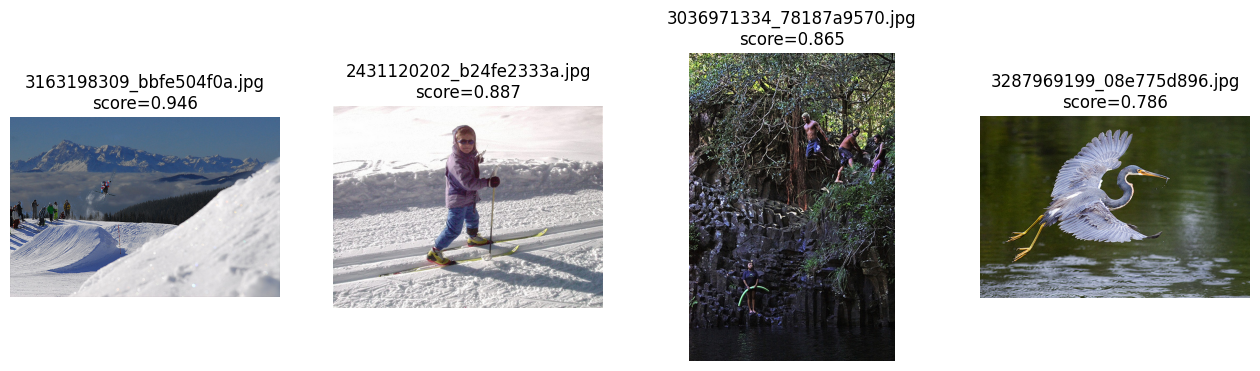

Релевантное (не в Top-4): 3386953179_84c2d7922f.jpg


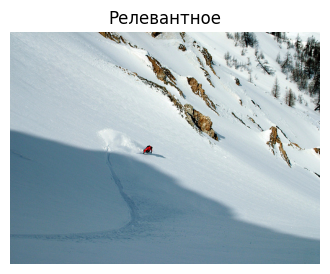

--------------------------------------------------------------------------------
Запрос: Young boys enjoying a spray of water .
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: A little boy is flying a kite high up in the air .
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------
Запрос: The brown German shepherd dog is playing with a stick .
Top-4: [('634891010_9fa189effb.jpg', 0.315), ('2986716822_e220754d32.jpg', 0.117), ('957682378_46c3b07bcd.jpg', 0.08), ('1745110280_0cbff5e273.jpg', 0.079)]


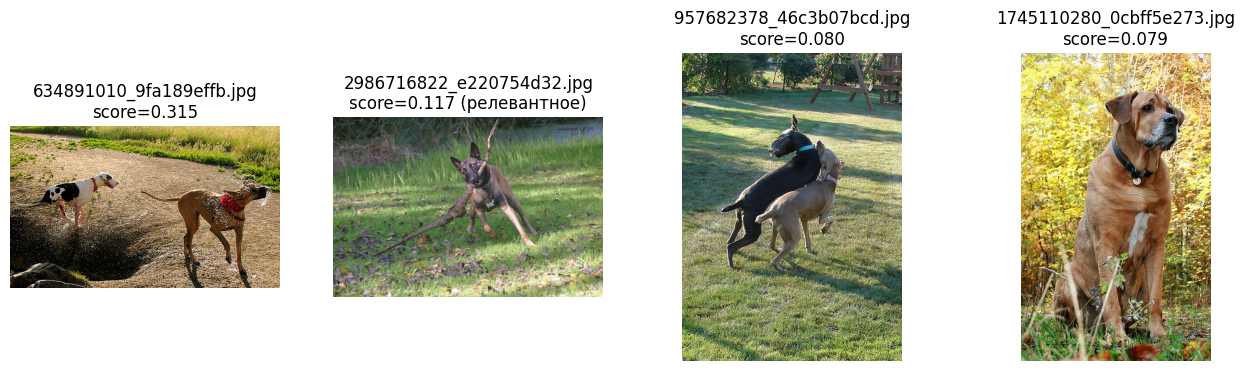

--------------------------------------------------------------------------------
Запрос: A group of people gather on the grass field and throw a pink hoop .
Top-4: [('2517284816_9b8fd3c6b6.jpg', 0.646), ('1991806812_065f747689.jpg', 0.393), ('3119913014_688d4997d7.jpg', 0.263), ('3287969199_08e775d896.jpg', 0.127)]


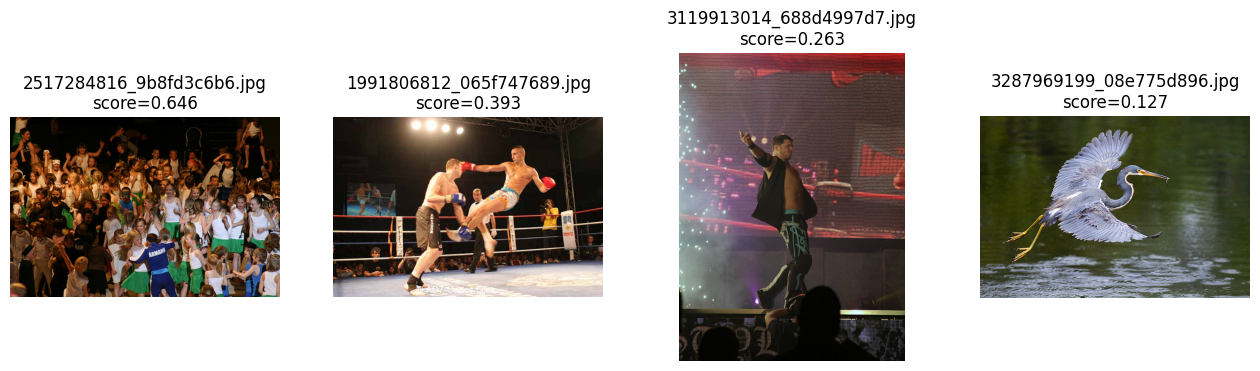

Релевантное (не в Top-4): 2121140070_a09644550b.jpg


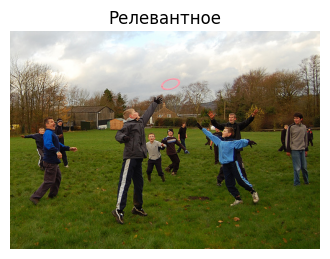

--------------------------------------------------------------------------------
Запрос: Two black dogs fighting over an orange toy .
Top-4: [('2986716822_e220754d32.jpg', 0.48), ('634891010_9fa189effb.jpg', 0.478), ('3466891862_9afde75568.jpg', 0.321), ('957682378_46c3b07bcd.jpg', 0.255)]


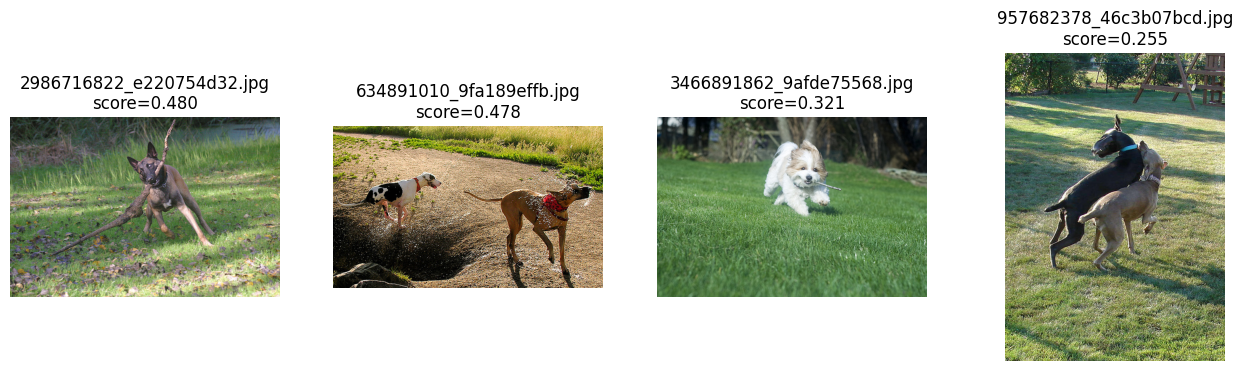

Релевантное (не в Top-4): 3553476195_fb3747d7c1.jpg


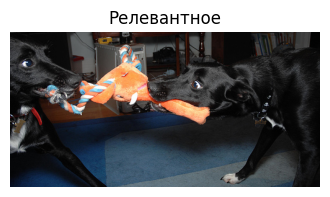

--------------------------------------------------------------------------------
Запрос: An asian lady in a red jacket taking a photo
Top-4: [('3287969199_08e775d896.jpg', 0.866), ('3393035454_2d2370ffd4.jpg', 0.033), ('2141713971_e25eb12712.jpg', 0.023), ('3163198309_bbfe504f0a.jpg', 0.013)]


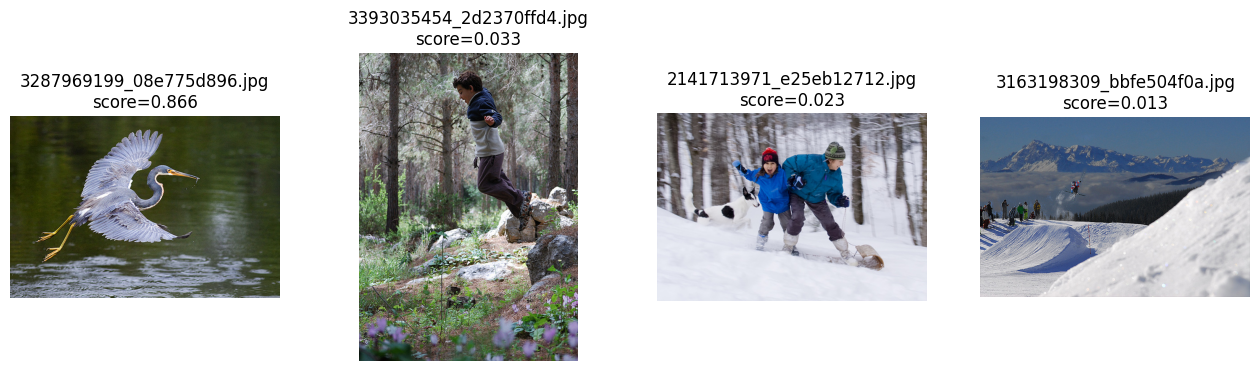

Релевантное (не в Top-4): 404850242_3a55a4c874.jpg


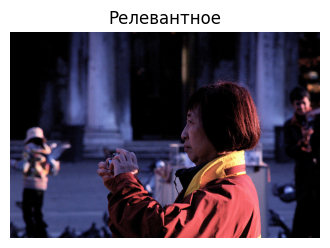

--------------------------------------------------------------------------------
Запрос: a lone man sitting on a ledge that overlooks the beach
Top-4: [('3287969199_08e775d896.jpg', 0.983), ('3036971334_78187a9570.jpg', 0.601), ('3163198309_bbfe504f0a.jpg', 0.386), ('2431120202_b24fe2333a.jpg', 0.202)]


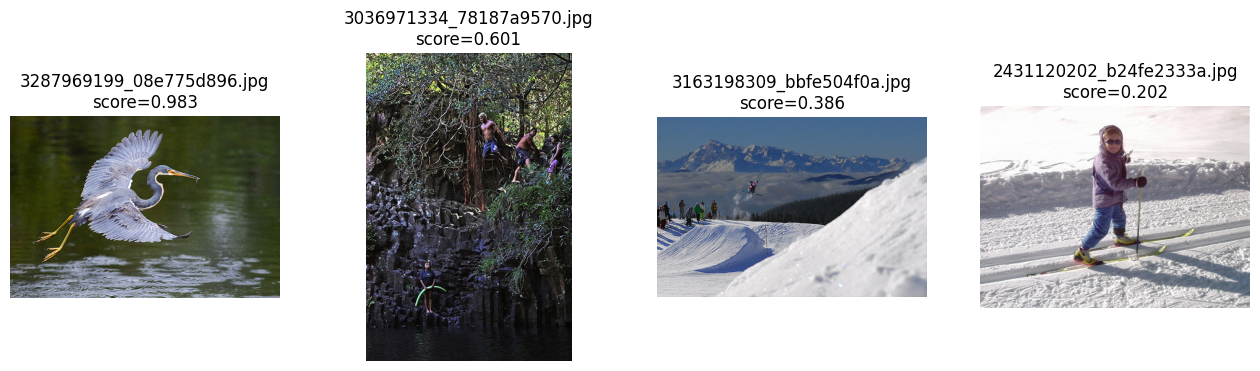

Релевантное (не в Top-4): 345785626_9fa59f38ce.jpg


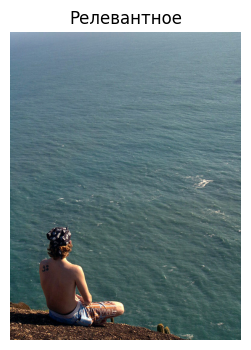

--------------------------------------------------------------------------------
Запрос: A black dog holds a small white dumbbell in its mouth .
Top-4: [('634891010_9fa189effb.jpg', 0.97), ('3514297698_0512623955.jpg', 0.945), ('2986716822_e220754d32.jpg', 0.772), ('957682378_46c3b07bcd.jpg', 0.744)]


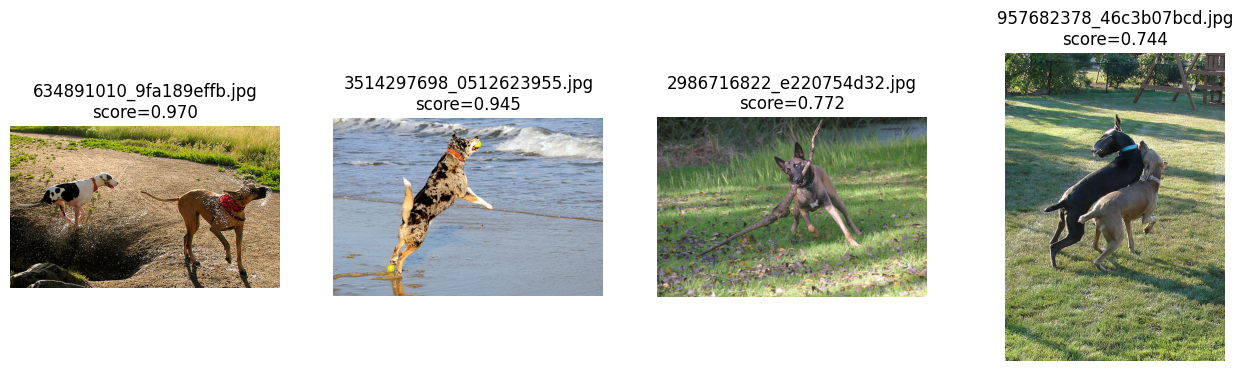

Релевантное (не в Top-4): 989851184_9ef368e520.jpg


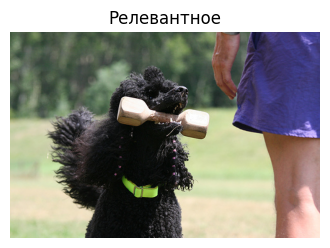

--------------------------------------------------------------------------------
Запрос: Two children play with a white dog .
This image is unavailable in your country in compliance with local laws
--------------------------------------------------------------------------------


In [13]:
DISCLAIMER = "This image is unavailable in your country in compliance with local laws"


def show_image(image_path: Path, title: str | None = None):
    if not image_path.exists():
        print(f"Файл не найден: {image_path}")
        return
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


def search_best_image(query_text: str, top_k: int = 1):
    if is_restricted_query(query_text):
        return None, DISCLAIMER

    if not test_image_embeddings:
        return None, "Нет эмбеддингов test изображений. Проверьте путь к данным."

    text_vec = encode_text(query_text, best_bundle["text_pipeline"])
    image_names = list(test_image_embeddings.keys())
    X_query = build_query_matrix(text_vec, image_names, test_image_embeddings, best_bundle["text_pipeline"])
    scores = predict_scores(best_bundle, X_query)

    top_idx = np.argsort(scores)[::-1][:top_k]
    results = [(image_names[i], float(scores[i])) for i in top_idx]
    return results, None

# Диагностика повторяющихся топ-1
RUN_DIAGNOSTICS = True
if RUN_DIAGNOSTICS:
    image_names = list(test_image_embeddings.keys())
    print("Test images:", len(image_names))

    diag_queries = test_queries.sample(n=min(30, len(test_queries)), random_state=None)
    top1_list = []
    scores_list = []

    for _, row in diag_queries.iterrows():
        results, error = search_best_image(row["query_text"], top_k=1)
        if error:
            continue
        top1_list.append(results[0][0])
        scores_list.append(results[0][1])

    if top1_list:
        unique_top1 = len(set(top1_list))
        print(f"Top-1 уникальных: {unique_top1}/{len(top1_list)}")
        print("Самые частые Top-1:")
        print(pd.Series(top1_list).value_counts().head(5))
        print("Score summary:")
        print(pd.Series(scores_list).describe())
    else:
        print("Диагностика: нет результатов (возможно, все запросы отфильтрованы).")

# Демо на 10 случайных запросах
TOP_K = 4
sample_queries = test_queries.sample(n=10, random_state=None)

for _, row in sample_queries.iterrows():
    query_text = row["query_text"]
    gt_image = row["image"]

    print("Запрос:", query_text)
    results, error = search_best_image(query_text, top_k=TOP_K)

    if error:
        print(error)
        print("-" * 80)
        continue

    top_names = [name for name, _ in results]
    print("Top-4:", [(name, round(score, 3)) for name, score in results])

    fig, axes = plt.subplots(1, TOP_K, figsize=(4 * TOP_K, 4))
    if TOP_K == 1:
        axes = [axes]

    for ax, (image_name, score) in zip(axes, results):
        image_path = TEST_IMAGES_DIR / image_name
        if image_path.exists():
            img = Image.open(image_path).convert("RGB")
            ax.imshow(img)
        ax.axis("off")
        marker = " (релевантное)" if image_name == gt_image else ""
        ax.set_title(f"{image_name}\nscore={score:.3f}{marker}")

    plt.show()

    if isinstance(gt_image, str) and gt_image and gt_image not in top_names:
        print(f"Релевантное (не в Top-{TOP_K}): {gt_image}")
        show_image(TEST_IMAGES_DIR / gt_image, title="Релевантное")

    print("-" * 80)


## 8. Выводы

- [x] Jupyter Notebook открыт
- [ ] Весь код выполняется без ошибок
- [ ] Ячейки с кодом расположены в порядке исполнения
- [ ] Исследовательский анализ данных выполнен
- [ ] Проверены экспертные оценки и краудсорсинговые оценки
- [ ] Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ] Изображения векторизованы
- [ ] Текстовые запросы векторизованы
- [ ] Данные корректно разбиты на тренировочную и тестовую выборки
- [ ] Предложена метрика качества работы модели
- [ ] Предложена модель схожести изображений и текстового запроса
- [ ] Модель обучена
- [ ] По итогам обучения модели сделаны выводы
- [ ] Проведено тестирование работы модели
- [ ] По итогам тестирования визуально сравнили качество поиска

Дополнительные выводы:
- Лучшая комбинация (целевая стратегия + модель) определяется по Recall@K и MAE — см. сводную таблицу метрик выше.
- Типичные ошибки: похожие сцены с разными объектами, слабое различение действий, приоритет фона над ключевым объектом.
- Проект реализуем как PoC: качество подтверждается метриками и визуальной проверкой, но для продакшена нужны большие данные, модерация и ANN-индекс.
